# Is Seattle Really Seeing an Uptick in Cycling? (2023 Update)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
cycle_raw = pd.read_csv('Fremont_Bridge_Bicycle_Counter_2023.csv', index_col = 'Date', parse_dates = True)
weather_raw = pd.read_csv('SeaTacWeather_2023.csv', index_col = 'DATE', parse_dates = True, usecols=['DATE', 'PRCP', 'TMAX', 'TMIN'])

In [3]:
cycle = cycle_raw.copy()
weather = weather_raw.copy()

In [4]:
cycle = cycle.sort_index()

The bicycle count data was obtained from official Seattle Government website [Fremont Bridge Bicycle Counter](https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k).

The data being used is from March 2021 - March 2023

In [5]:
cycle = cycle['2021-03-01':'2023-03-01']
cycle.head() # This is hourly data

,"Fremont Bridge Sidewalks, south of N 34th St","Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk","Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk"
Date,,,
2021-03-01 00:00:00,0.0,0.0,0.0
2021-03-01 01:00:00,0.0,0.0,0.0
2021-03-01 02:00:00,0.0,0.0,0.0
2021-03-01 03:00:00,1.0,1.0,0.0
2021-03-01 04:00:00,6.0,1.0,5.0


In [6]:
cycle.shape

(17520, 3)

In [7]:
cycle.columns = ['total', 'east_sidewalk', 'west_sidewalk']

Resampling the hourly data to daily and weekly data

In [8]:
cycle_daily = cycle.resample('d').sum() # Day by day data
print(cycle_daily.shape)
cycle_daily.head()

(730, 3)


,total,east_sidewalk,west_sidewalk
Date,,,
2021-03-01,1581.0,642.0,939.0
2021-03-02,1408.0,553.0,855.0
2021-03-03,2307.0,967.0,1340.0
2021-03-04,1122.0,443.0,679.0
2021-03-05,857.0,344.0,513.0


In [9]:
cycle_weekly = cycle.resample('w').sum() # weekly data
print(cycle_weekly.shape)
cycle_weekly.head()

(105, 3)


,total,east_sidewalk,west_sidewalk
Date,,,
2021-03-07,9751.0,4078.0,5673.0
2021-03-14,13038.0,5524.0,7514.0
2021-03-21,9774.0,4078.0,5696.0
2021-03-28,10767.0,4450.0,6317.0
2021-04-04,14611.0,6253.0,8358.0


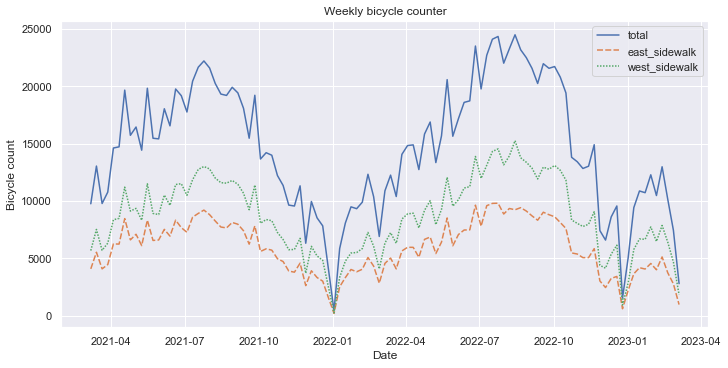

In [10]:
plt.figure(figsize = (10,5), layout = 'constrained')
sns.lineplot(data = cycle_weekly)
plt.ylabel('Bicycle count')
plt.title('Weekly bicycle counter');

Moving average of the daily data is taken to better understand the trend in data - Window of 30 days is chosen to smoothen the curve

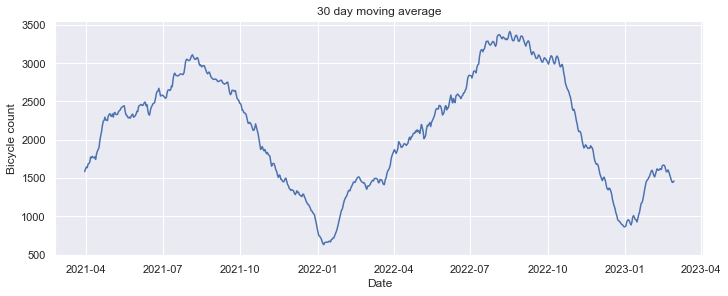

In [11]:
plt.figure(figsize = (10,4), layout = 'constrained')
cycle_daily_rolling = cycle_daily.total.rolling(30).mean()
sns.lineplot(data = cycle_daily_rolling)
plt.ylabel('Bicycle count')
plt.title('30 day moving average');

# Introducing variables for modelling

### 1. Hours of daylight

Looking at the trend from the moving average there is a seasonal change in the bicycle count over 2 year period and this seems to be aligned with the hours of daylight in the Seattle area.

We know that the hours in a day follows a periodic pattern and it depends on the location, the script below will help us compute the hours in a day in the Seattle region.

In [12]:
# Compute the hours of daylight for the given date using latitude
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    day = (date - pd.to_datetime('2000-12-21'))//np.timedelta64(1,"D")  # 21 Dec = Shortest day of the year
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

# Add this to our weekly data
cycle_weekly['daylight'] = hours_of_daylight(cycle_weekly.index)
cycle_daily['daylight'] = hours_of_daylight(cycle_daily.index)

Plotting the hours of daylight shows us that the days are longer in June-July and shorter around December-January

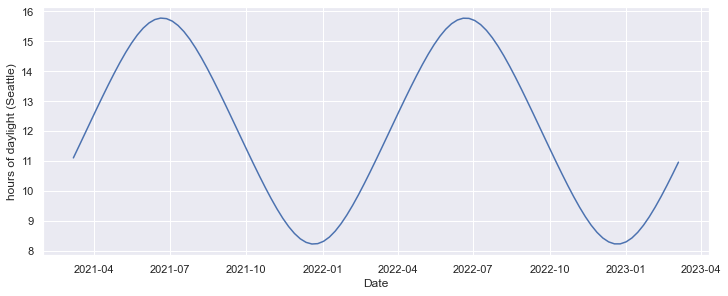

In [13]:
# Daylight curve in Seattle
plt.figure(figsize = (10,4), layout = 'constrained')
sns.lineplot(data = cycle_weekly['daylight'])
plt.ylabel('hours of daylight (Seattle)');

In [14]:
cycle_daily.daylight.loc[cycle_daily.daylight == cycle_daily.daylight.max()] # Summer solstace

Date
2022-06-22    15.781095
Freq: D, Name: daylight, dtype: float64

From the plot below it is clear that there is a positive correlation between hours of daylight and bicycle count

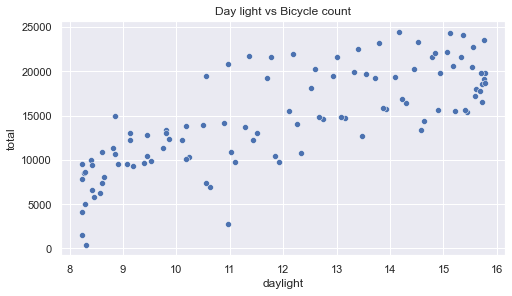

In [15]:
plt.figure(figsize = (7,4), layout = 'constrained')
sns.scatterplot(data = cycle_weekly, x = 'daylight', y = 'total')
plt.title('Day light vs Bicycle count');

To quantify the relation between day light and bicycle count let's try to fit a linear regression line

In [16]:
from sklearn.linear_model import LinearRegression
X = cycle_weekly['daylight'].values.reshape(-1, 1)
y = cycle_weekly['total']
lin_model1 = LinearRegression().fit(X, y)
X_test = np.arange(7, 17).reshape(-1, 1)
y_pred = lin_model1.predict(X_test)

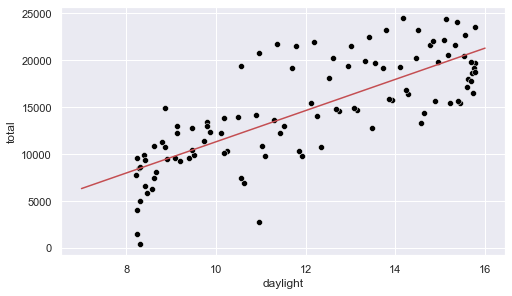

In [17]:
plt.figure(figsize = (7,4), layout = 'constrained')
sns.scatterplot(data = cycle_weekly, x = 'daylight', y = 'total', color = 'black')
sns.lineplot(x = np.arange(7, 17), y = y_pred, color = 'r');

In [18]:
lin_model1.coef_[0]

1660.8579394714693

From the coefficient we can tell that for every extra hour of daylight there are 1600 more bicycle counts, granted that day light might not be the only factor at play here (from the spread in the data).

In [19]:
cycle_weekly['daylight_trend'] = lin_model1.predict(X)

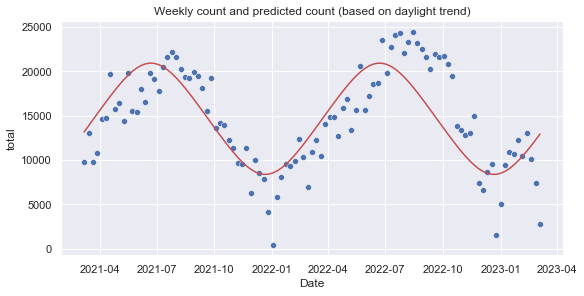

In [20]:
plt.figure(figsize = (8,4), layout = 'constrained')
sns.scatterplot(data = cycle_weekly.total)
sns.lineplot(data = cycle_weekly.daylight_trend, color = 'r')
plt.title('Weekly count and predicted count (based on daylight trend)');

Now let's try to remove the effect of day light from the data (de-trending). The daylight_corrected_total can be thought of as the data if daylight was not a factor.

De-trending is done by subtracting the target by predicted values and replacing it with mean of prediction.

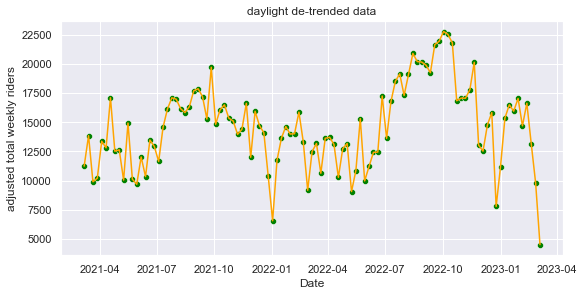

In [21]:
cycle_weekly['daylight_corrected_total'] = cycle_weekly['total'] - cycle_weekly['daylight_trend'] + cycle_weekly['daylight_trend'].mean()
plt.figure(figsize = (8,4), layout = 'constrained')
sns.scatterplot(data = cycle_weekly['daylight_corrected_total'], color = 'green')
sns.lineplot(data = cycle_weekly['daylight_corrected_total'], color = 'orange')
plt.ylabel('adjusted total weekly riders')
plt.title('daylight de-trended data');

Checking the standard devation of the data before and after detrending 

In [22]:
# rms about daylight trend
print(round(np.std(cycle_weekly['total'])))
round(np.std(cycle_weekly['daylight_corrected_total'].values))

5578


3532

### 2. Day of the week

It is a well known fact that people in the city of Seattle use cycles to commute to their work therefore the day of the week must be an influential feature in the fluctuation of the daily ridership

In [23]:
cycle_daily['day_of_week'] = cycle_daily.index.day_of_week

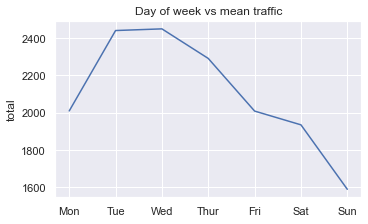

In [24]:
dayofweek_avg = cycle_daily.groupby('day_of_week')['total'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
dayofweek_avg.index = days
plt.figure(figsize = (5,3), layout = 'constrained')
sns.lineplot(data = dayofweek_avg)
plt.title('Day of week vs mean traffic');

From the plot it is obvious that there is reduced cycle traffic on non business days

Since day_of_week is a categorical column we apply one hot encoding to use it as a feature in the linear model

In [25]:
day_of_week_ohe = pd.get_dummies(cycle_daily.day_of_week)
day_of_week_ohe.columns = days
X = pd.concat([day_of_week_ohe, cycle_daily['daylight']], axis = 1)
y = cycle_daily.total
lin_model2 = LinearRegression().fit(X, y)
cycle_daily['dayofweek_trend'] = lin_model2.predict(X)

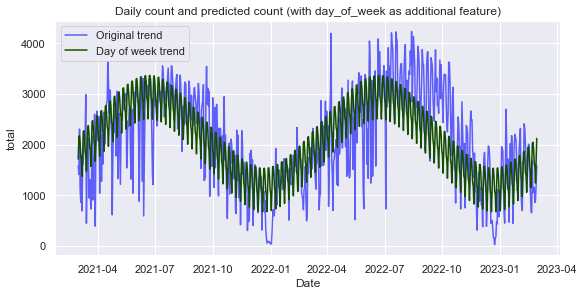

In [26]:
plt.figure(figsize = (8, 4), layout = 'constrained')
sns.lineplot(data = cycle_daily['total'], color = '#0000ff', alpha = 0.6, label = 'Original trend')
sns.lineplot(data = cycle_daily['dayofweek_trend'], color = '#134d00', label = 'Day of week trend')
plt.title('Daily count and predicted count (with day_of_week as additional feature)')
plt.legend();

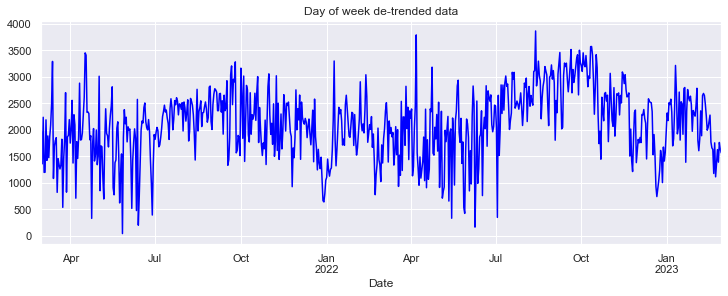

In [27]:
# day of week corrected trend
cycle_daily['dayofweek_corrected'] = cycle_daily['total'] - cycle_daily['dayofweek_trend'] + cycle_daily['dayofweek_trend'].mean()
plt.figure(figsize = (10, 4), layout = 'constrained')
cycle_daily['dayofweek_corrected'].plot(color = '#0000ff')
plt.title('Day of week de-trended data');

By adding day_of_week as a feature we are further able to reduce the variance after de-trending

In [28]:
# rms about daylight and day of week trend
round(np.std(cycle_daily['dayofweek_corrected']))

651

### 3. Daily Weather (Temperature & Precipitation)

Cycling is not the most convinent means of transportation on a day with bad weather therefore weather data must have an impact on the ridership count

In [29]:
weather = weather.loc['2021-03-01':'2023-02-28', :]
print(weather.shape)
weather.head()

(730, 3)


,PRCP,TMAX,TMIN
DATE,,,
2021-03-01,0.00,57,38
2021-03-02,0.00,50,40
2021-03-03,0.00,56,35
2021-03-04,0.30,53,37
2021-03-05,0.04,53,44


In [30]:
weather_weekly = pd.DataFrame()

In [31]:
weather_weekly['TMIN'] = weather['TMIN'].resample('w').min()
weather_weekly['TMAX'] = weather['TMAX'].resample('w').max()
weather_weekly['PRCP'] = weather['PRCP'].resample('w').sum()

In [32]:
weather_weekly.head()

,TMIN,TMAX,PRCP
DATE,,,
2021-03-07,35,57,0.49
2021-03-14,31,60,0.29
2021-03-21,33,59,0.52
2021-03-28,38,54,1.31
2021-04-04,34,63,0.00


Plotting the temperature data corresponds with the seasons in Seattle area, we see higher temperatures in June-July (summer: June - September)

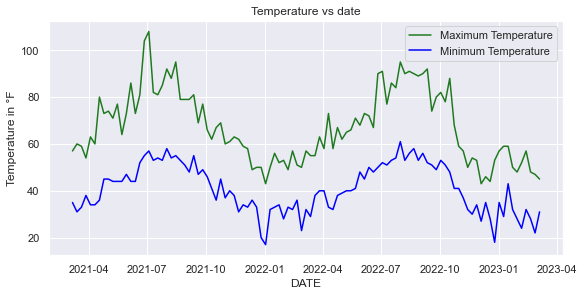

In [33]:
plt.figure(figsize = (8, 4), layout = 'constrained')
sns.lineplot(data = weather_weekly['TMAX'], color = '#1f7a1f', label = 'Maximum Temperature')
sns.lineplot(data = weather_weekly['TMIN'], color = '#0000ff', label = 'Minimum Temperature')
plt.title('Temperature vs date')
plt.ylabel('Temperature in °F');

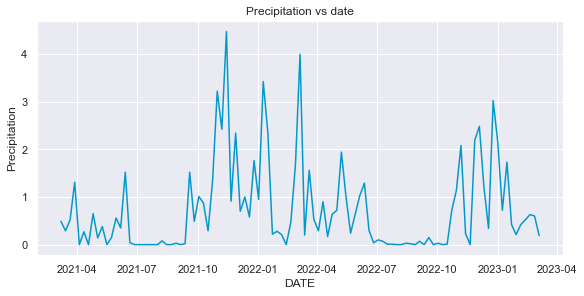

In [34]:
plt.figure(figsize = (8, 4), layout = 'constrained')
sns.lineplot(data = weather_weekly['PRCP'], color = '#0099cc')
plt.title('Precipitation vs date')
plt.ylabel('Precipitation');

In [35]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2021-03-01 to 2023-02-28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRCP    727 non-null    float64
 1   TMAX    730 non-null    int64  
 2   TMIN    730 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 22.8 KB


In [36]:
weather.PRCP.loc[weather.PRCP.isna()]

DATE
2021-12-18   NaN
2021-12-28   NaN
2021-12-30   NaN
Name: PRCP, dtype: float64

In [37]:
X_weather = pd.concat([day_of_week_ohe, cycle_daily['daylight'], weather], axis = 1).dropna(axis = 0)
y = cycle_daily.total.drop(weather.PRCP.loc[weather.PRCP.isna()].index.to_list(), axis = 0)
lin_model3 = LinearRegression().fit(X_weather, y)

In [38]:
cycle_daily1 = cycle_daily.drop(weather.PRCP.loc[weather.PRCP.isna()].index.to_list(), axis = 0)

Training model number 3 with weather (temperature and precipitation) as an extra added feature

In [39]:
cycle_daily1['overall_trend'] = lin_model3.predict(X_weather)

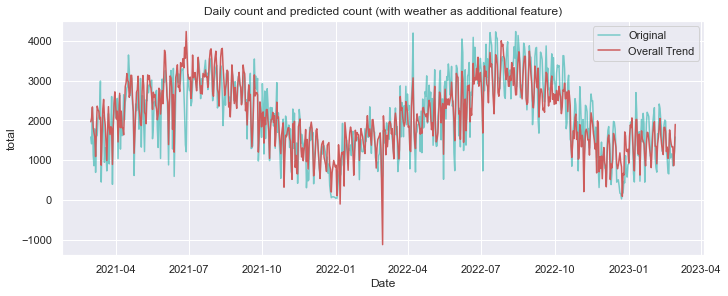

In [40]:
plt.figure(figsize = (10, 4), layout = 'constrained')
sns.lineplot(data = cycle_daily1.total, color = '#03A89E', alpha = 0.5, label = 'Original')
sns.lineplot(data = cycle_daily1.overall_trend, color = '#CD5C5C', label = 'Overall Trend')
plt.title('Daily count and predicted count (with weather as additional feature)')
plt.legend();

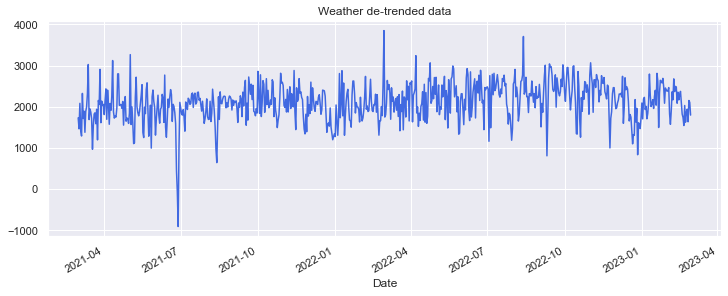

In [41]:
cycle_daily1['overall_corrected'] = cycle_daily1['total'] - cycle_daily1['overall_trend'] + cycle_daily1['overall_trend'].mean()
plt.figure(figsize = (10, 4), layout = 'constrained')
cycle_daily1['overall_corrected'].plot(color = '#4169E1')
plt.title('Weather de-trended data');

By adding weather as a feature we have further reduced the variance after de-trending

In [42]:
# rms about overall trend
print(np.std(cycle_daily1['overall_corrected']))

458.6157305164806


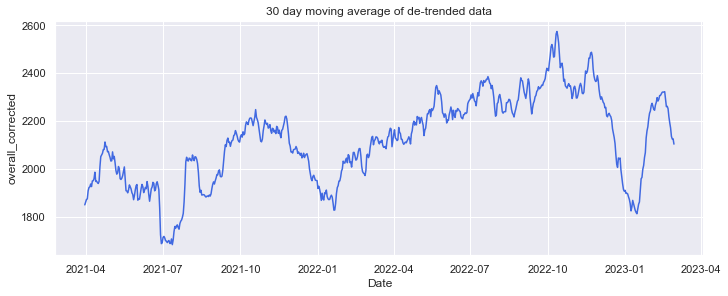

In [43]:
cycle_daily1_corrected_rolling = cycle_daily1['overall_corrected'].rolling(30).mean()
plt.figure(figsize = (10, 4), layout = 'constrained')
sns.lineplot(data = cycle_daily1_corrected_rolling, color = '#4169E1')
plt.title('30 day moving average of de-trended data');

### Accounting for Increase or Decrease of Riders

As a final model, we'll add-in the day index to allow our model to account for an overall increase or decrease in the number of riders with time

In [44]:
cycle_daily['daycount'] = np.arange(len(cycle_daily))
X_final = pd.concat([day_of_week_ohe, cycle_daily['daylight'], weather, cycle_daily['daycount']], axis = 1).dropna(axis = 0)
y = cycle_daily.total.drop(weather.PRCP.loc[weather.PRCP.isna()].index.to_list(), axis = 0)
lin_model4 = LinearRegression().fit(X_final, y)

In [45]:
cycle_daily1['final_trend'] = lin_model4.predict(X_final)

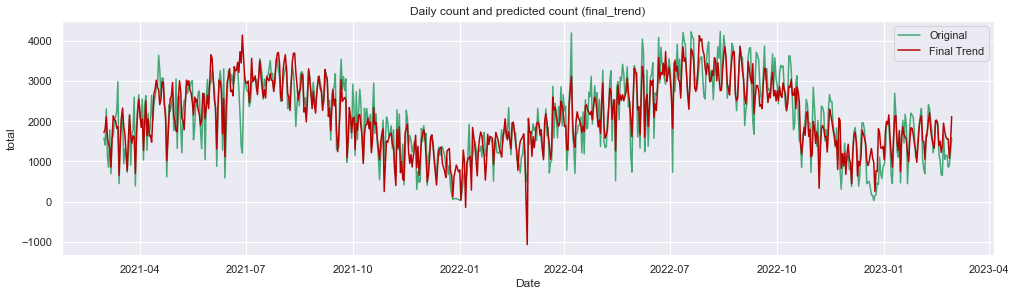

In [46]:
plt.figure(figsize = (14, 4), layout = 'constrained')
sns.lineplot(data = cycle_daily1.total, color = '#008B45', alpha = 0.7, label = 'Original')
sns.lineplot(data = cycle_daily1.final_trend, color = '#B70404', label = 'Final Trend')
plt.title('Daily count and predicted count (final_trend)')
plt.legend();

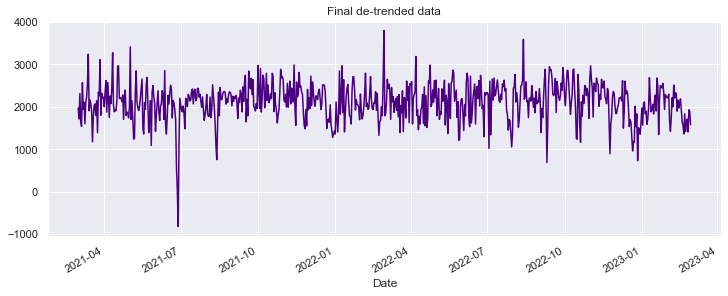

In [47]:
cycle_daily1['final_corrected'] = cycle_daily1['total'] - cycle_daily1['final_trend'] + cycle_daily1['final_trend'].mean()
plt.figure(figsize = (10, 4), layout = 'constrained')
cycle_daily1['final_corrected'].plot(color = '#4B0082')
plt.title('Final de-trended data');

In [48]:
# rms about final trend
print(round(np.std(cycle_daily1['final_corrected'])))

442


### What Can The Final Model Tell Us?

We could now use the final model to answer the affects of each feature on the ridership and finally if there is an uptick or downtick in ridership

Let us construct a error-covariance matrix from which we can obtain error bars for each features

In [49]:
vy = np.sum((y - cycle_daily1['final_trend']) ** 2) / len(y) # Variance of least square estimator
X2 = np.hstack([X_final, np.ones((X_final.shape[0], 1))]) # Design matrix with extra column of 1's for intercept
C = vy * np.linalg.inv(np.dot(X2.T, X2)) # Error covariance matrix
var = C.diagonal() 

In [50]:
columns = X_final.columns.to_list()

In [51]:
lin_model4.coef_

array([-8.35076277e+01,  3.42875449e+02,  2.93206830e+02,  2.09171619e+02,
       -9.05073905e+01, -1.79610244e+02, -4.91628636e+02,  9.11832322e+01,
       -9.23834017e+02,  4.52046503e+01, -1.47453776e+01,  6.19614146e-01])

### How Does Rain Affect Ridership?

In [52]:
ind = columns.index('PRCP')
slope = lin_model4.coef_[ind]
error = np.sqrt(var[ind]) # Std deviation of error terms
print(f'{round(-slope)} +/- {round(error)} daily crossings lost per inch of rain')

924 +/- 70 daily crossings lost per inch of rain


### How Does Temperature Affect Ridership?

In [53]:
ind1 = columns.index('TMIN')
ind2 = columns.index('TMAX')
slope = lin_model4.coef_[ind1] + lin_model4.coef_[ind2]
error = np.sqrt(var[ind1] + var[ind2])
print(f'{round(slope)} +/- {round(error)} riders per degrees Fahrenheit')

30 +/- 5 riders per degrees Fahrenheit


### How does Daylight Affect Ridership?

In [54]:
ind = columns.index('daylight')
slope = lin_model4.coef_[ind]
error = np.sqrt(var[ind])
print(f'{round(slope)} +/- {round(error)} riders gained per hour of daylight')

91 +/- 10 riders gained per hour of daylight


### Is Ridership Increasing?

In [55]:
ind = columns.index('daycount')
slope = lin_model4.coef_[ind]
error = np.sqrt(var[ind])
print(f'{round(slope, 2)} +/- {round(error, 2)} new riders per day')
print(f'{round(7 * slope, 2)} +/- {round(7 * error, 2)} new riders per week')
print(f'Annual change: ({round(100 * 365 * slope / cycle_daily1.total.mean(), 2)} +/- {round(100 * 365 * error / cycle_daily1.total.mean(), 2)})%')

0.62 +/- 0.08 new riders per day
4.34 +/- 0.59 new riders per week
Annual change: (10.71 +/- 1.45)%


From the above cell we can conclude that corrected for temeprature, rain, day of week, and hours of daylight trend there has been a **10% annual increase** in the number of cycles seen on the Fermont Bridge